<a href="https://colab.research.google.com/github/HSAkash/Cauliflower-disease/blob/main/Cauliflower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Kaggle link
[Cauliflower Dataset](https://www.kaggle.com/datasets/noamaanabdulazeem/cauliflower-dataset/code)

## Import kaggle and auth
* Colab
* Jupyter notebook

In [7]:
# !pip install -q kaggle
# !mkdir ~/.kaggle
# ! cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json"  ~/.kaggle
# ! chmod 600 ~/.kaggle/kaggle.json

## Download data from kaggle

In [8]:
# ! kaggle datasets download -d apollo2506/eurosat-dataset

100% 2.04G/2.04G [01:18<00:00, 29.2MB/s]
100% 2.04G/2.04G [01:18<00:00, 27.9MB/s]


In [9]:
# ! cp "/content/eurosat-dataset.zip" "/content/drive/MyDrive/Colab Notebooks/Thesis"

# Coding
* Data split (train, test)
* Data scaling and augmentaion
* EfficientNetB0 model
* Finetuning base model:
  * layer: 202 - 236
  * Last 5 layer trainable after every 20 epoch
  * lr: lr *= 0.9 (every 20 epoch later)


## Data

In [2]:
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/eurosat-dataset.zip"

### Set image path

In [3]:
datasets_dir = "/content/EuroSAT"

## For kaggle
# datasets_dir = "../input/cauliflower-dataset/Original Dataset"

### Load data from directory
* Split data set into train and test dataset

In [4]:
IMG_SIZE = 128
BATCH_SIZE = 32
epochs = 20

In [5]:
import tensorflow as tf
tf.random.set_seed(42)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size =  (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

### Data augmentation

In [6]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

### Visualize data

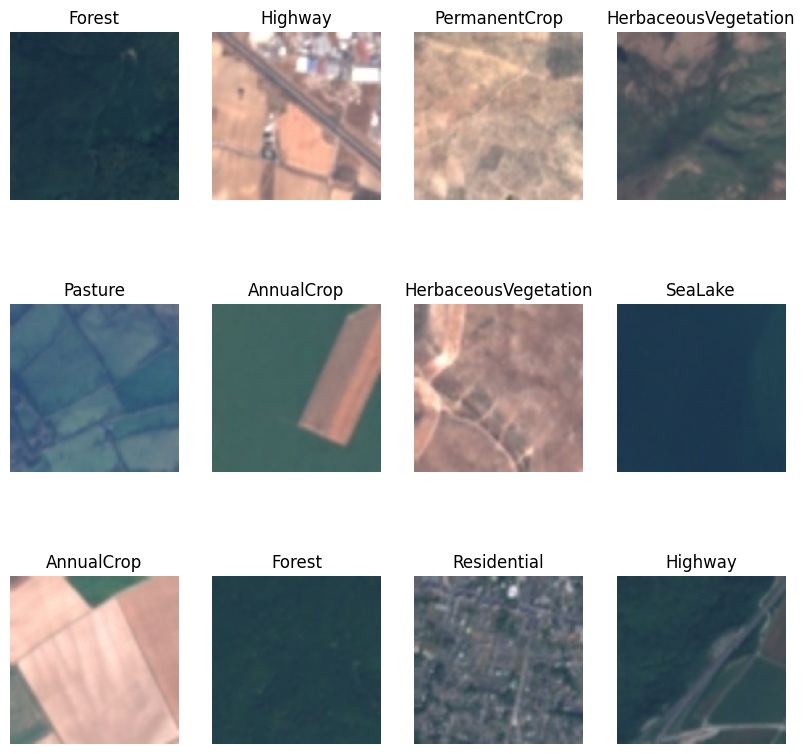

In [7]:
import matplotlib.pyplot as plt
import numpy as np

"""
ploting image
"""

plt.figure(figsize=(10,10))
"""
Take only one batch
Each batch size is now 32
so Every batch has 32 images
"""
for image_batch,label_batch in train_data.take(1):
    """Ploting only 8 pictures of them"""
    for i in range(0,12):
        """Subploting them 3 rows and 4 columns"""
        plt.subplot(3,4,i+1)
        """Image data 0-255"""
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

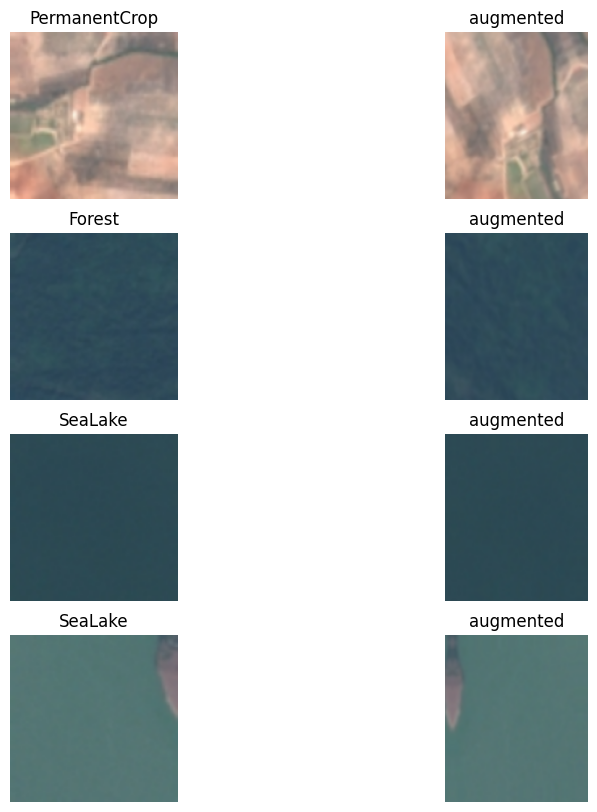

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        img = augmented_image_batch[i]
        img = np.array(img, dtype=np.int32)
        plt.imshow(img)
        plt.title(f"augmented")
        plt.axis("off")

## Create CheckPoint

In [9]:
gdrive_path = "/content/drive/MyDrive/Colab Notebooks/Thesis"

In [10]:
checkpoint_path =f"{gdrive_path}/CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True
)

## Transfer model model

In [11]:
import tensorflow as tf

# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

#Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


# CNN model

In [27]:
# import tensorflow as tf

# model = tf.keras.Sequential([
#     data_augmentation,





#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     tf.keras.layers.Conv2D(16, 3, activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=2),




#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

# ])


### Summary

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, None, None, 16)    0         
 g2D)                                                            
                                                        

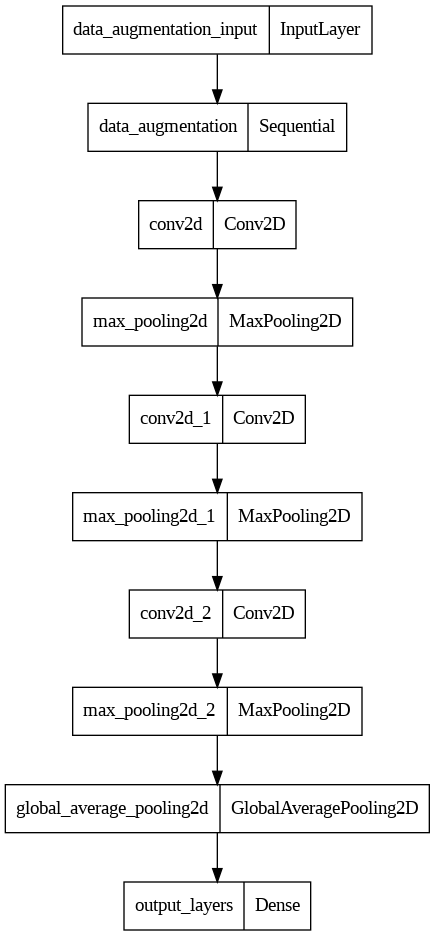

In [29]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    # show_shapes=True,
    # show_dtype=False,
    # show_layer_names=True,
    # rankdir='TB',
    # expand_nested=False,
    dpi=96,
    # layer_range=None,
    # show_layer_activations=False,
    # show_trainable=False
)

In [30]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [1]:
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

NameError: ignored

In [17]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

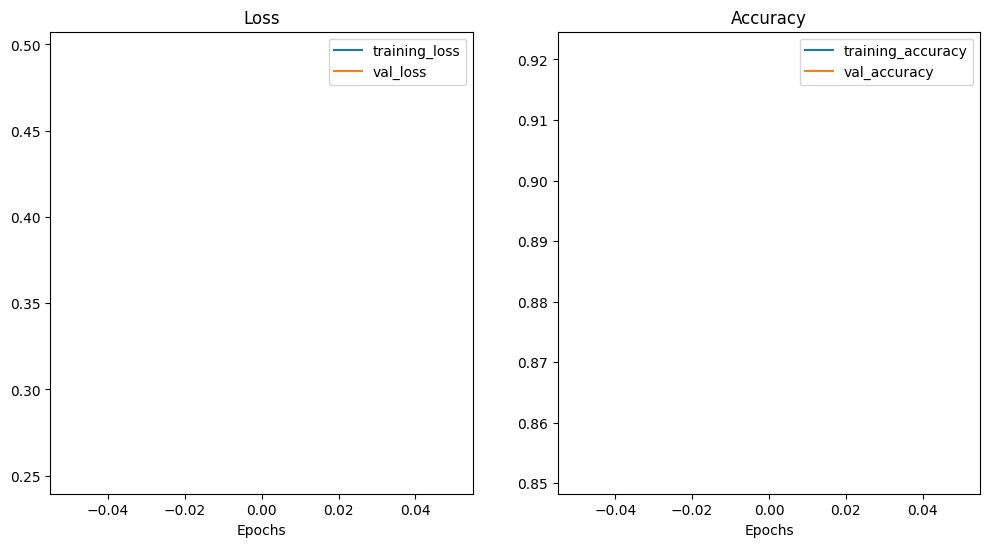

In [18]:
plot_loss_curves(history)

## Evaluate model

In [15]:
model.evaluate(train_data), model.evaluate(test_data)

169/169 [==============================] - 5s 31ms/step - loss: 0.2517 - accuracy: 0.9211


([0.26176226139068604, 0.9201388955116272],
 [0.25172191858291626, 0.9211111068725586])

In [19]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False):

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )

  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

In [ ]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)


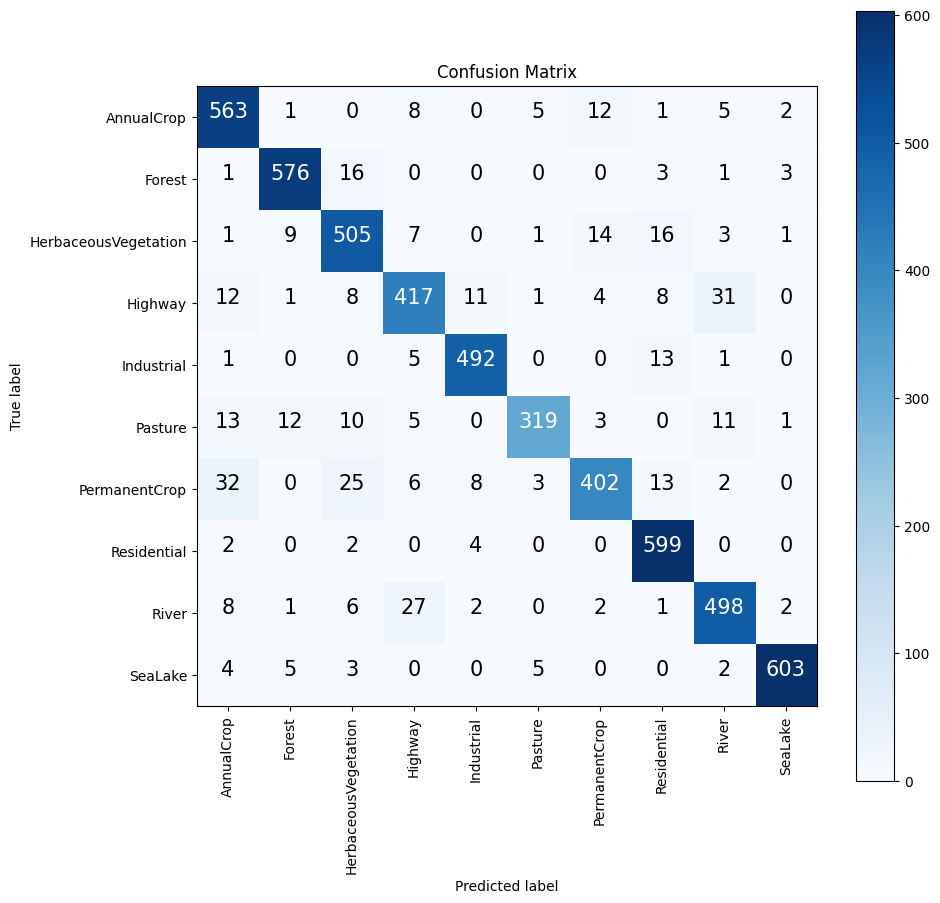

In [22]:
make_confusion_matrix(y_true, y_pred, class_names)

## Prediction && visualize

1/1 [==============================] - 0s 37ms/step


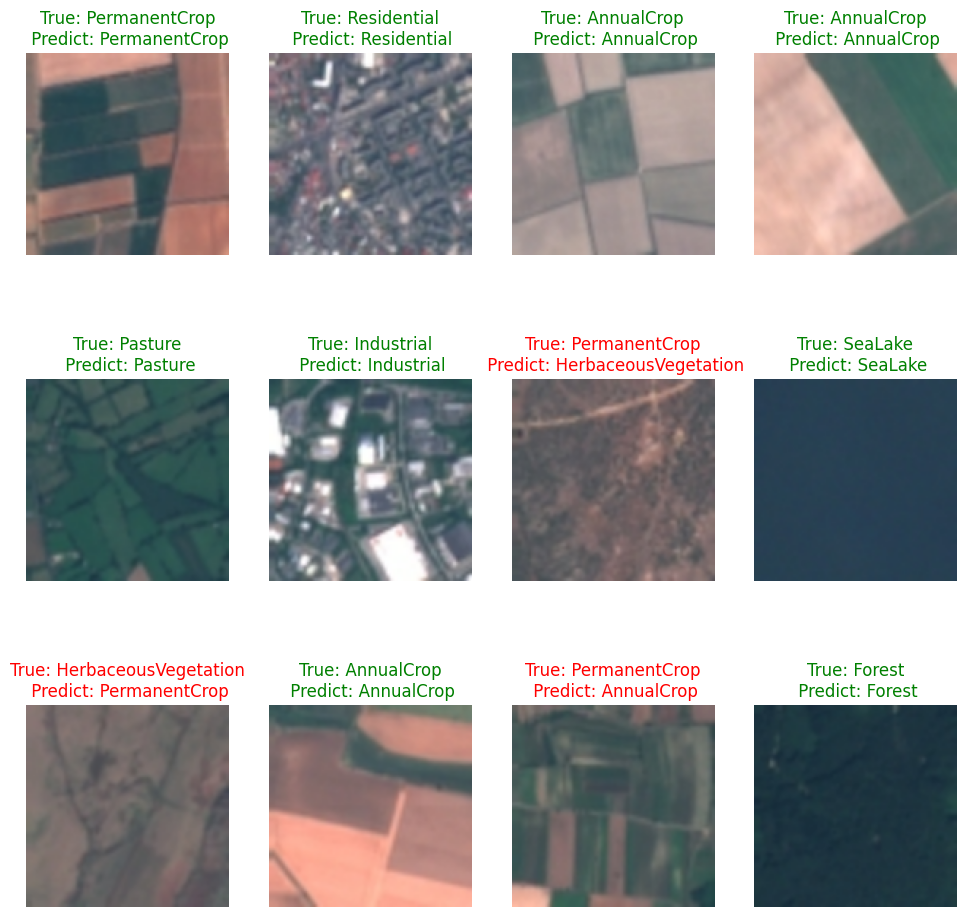

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")